In [19]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)


(True, 'NVIDIA GeForce GTX 1080 Ti')

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import pydicom

# Dataset configuration
DATA_DIR = "/srv/storage/talc@storage4.nancy/multispeech/corpus/speech_production/iadi"
SUBJECT = "ArtSpeech_Vocal_Tract_Segmentation/1612"
SEQUENCE = "S10"

# Path to the sequence
sequence_path = os.path.join(DATA_DIR, SUBJECT, SEQUENCE)
print(f"Sequence path: {sequence_path}")
print(f"Path exists: {os.path.exists(sequence_path)}")

# Check available folders
if os.path.exists(sequence_path):
    folders = [f for f in os.listdir(sequence_path) if os.path.isdir(os.path.join(sequence_path, f))]
    print(f"Available folders: {folders}")

Sequence path: /srv/storage/talc@storage4.nancy/multispeech/corpus/speech_production/iadi/ArtSpeech_Vocal_Tract_Segmentation/1612/S10
Path exists: True
Available folders: ['contours', 'dicoms', 'masks', 'NPY_MR']
Path exists: True
Available folders: ['contours', 'dicoms', 'masks', 'NPY_MR']


Total DICOM files: 18
Frames with masks: 6
First few frames with masks: ['0013', '0655', '1125', '1206', '1318', '1787']


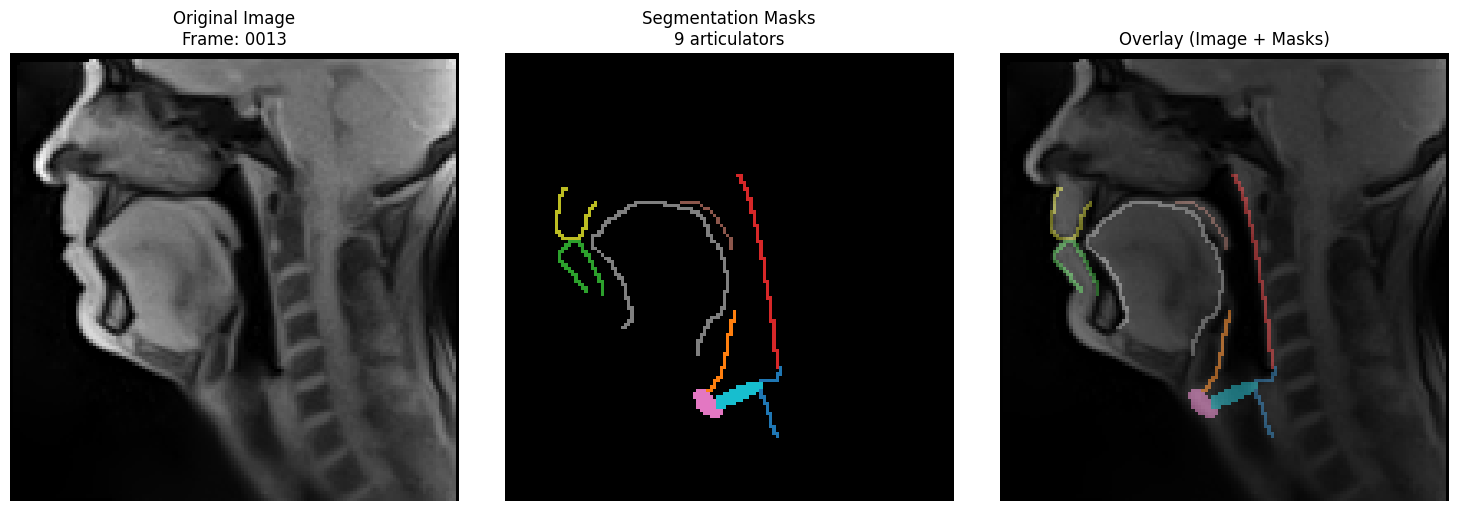


Frame 0013 - Annotated articulators: arytenoid-cartilage, epiglottis, lower-lip, pharynx, soft-palate-midline, thyroid-cartilage, tongue, upper-lip, vocal-folds
--------------------------------------------------------------------------------


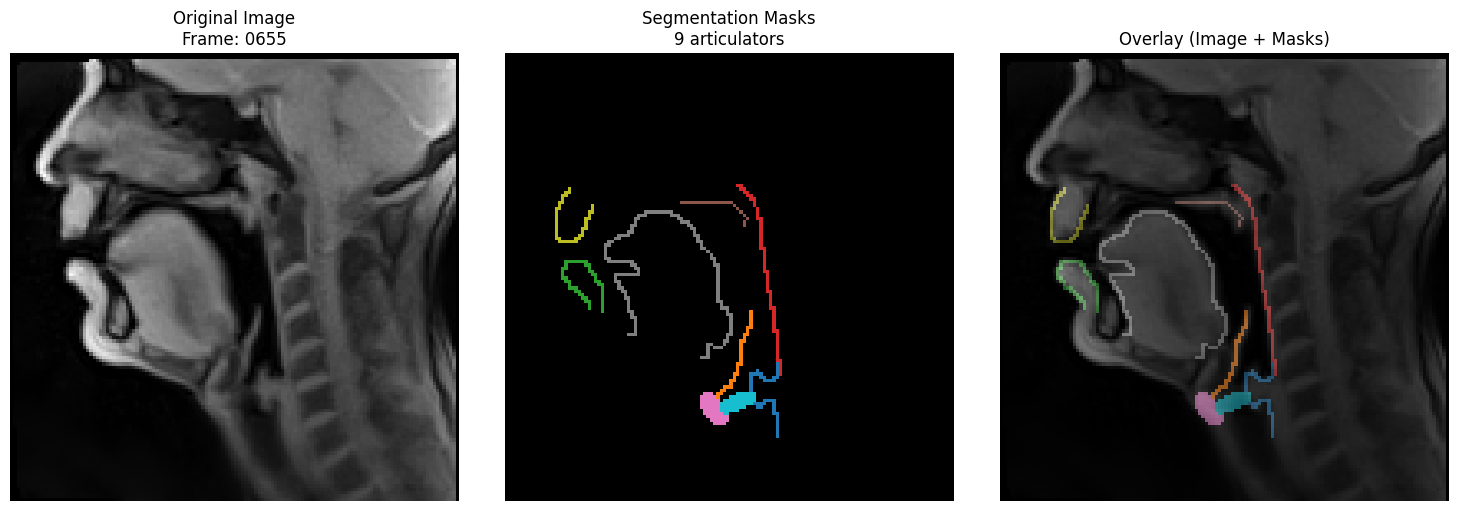


Frame 0655 - Annotated articulators: arytenoid-cartilage, epiglottis, lower-lip, pharynx, soft-palate-midline, thyroid-cartilage, tongue, upper-lip, vocal-folds
--------------------------------------------------------------------------------


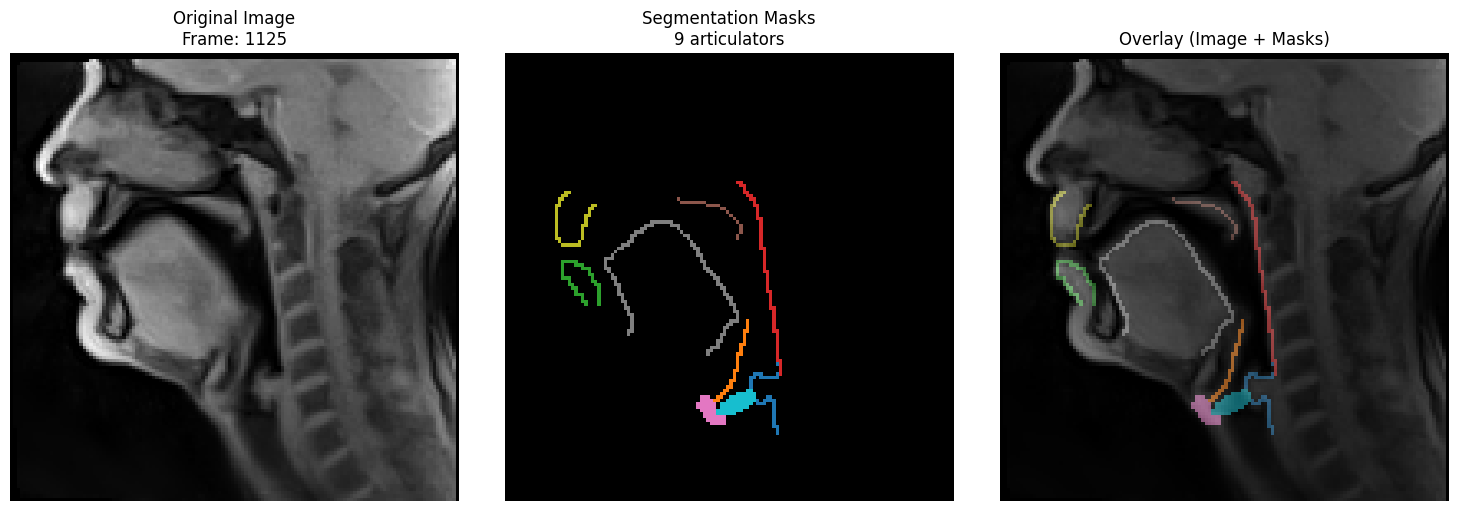


Frame 1125 - Annotated articulators: arytenoid-cartilage, epiglottis, lower-lip, pharynx, soft-palate-midline, thyroid-cartilage, tongue, upper-lip, vocal-folds
--------------------------------------------------------------------------------


In [21]:
# Get list of DICOM images
dicoms_path = os.path.join(sequence_path, 'dicoms')
masks_path = os.path.join(sequence_path, 'masks')

# Get all DICOM files
dicom_files = sorted(glob(os.path.join(dicoms_path, '*.dcm')))
print(f"Total DICOM files: {len(dicom_files)}")

# Get unique frame IDs that have masks
mask_files = glob(os.path.join(masks_path, '*.png'))
frame_ids_with_masks = sorted(set([os.path.basename(f).split('_')[0] for f in mask_files]))
print(f"Frames with masks: {len(frame_ids_with_masks)}")
print(f"First few frames with masks: {frame_ids_with_masks[:10]}")

# Load a few examples (let's take the first 3 annotated frames)
num_examples = min(3, len(frame_ids_with_masks))

# Class names from the config
classes = [
    'arytenoid-cartilage', 'epiglottis', 'lower-lip', 'pharynx',
    'soft-palate-midline', 'thyroid-cartilage', 'tongue', 'upper-lip', 'vocal-folds'
]

# Color map for different articulators
colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

for idx in range(num_examples):
    frame_id = frame_ids_with_masks[idx]
    
    # Load DICOM image
    dicom_path = os.path.join(dicoms_path, f"{frame_id}.dcm")
    dcm = pydicom.dcmread(dicom_path)
    img_array = dcm.pixel_array
    
    # Normalize image to 0-255
    img_normalized = ((img_array - img_array.min()) / (img_array.max() - img_array.min()) * 255).astype(np.uint8)
    
    # Load all masks for this frame
    masks_dict = {}
    for class_name in classes:
        mask_file = os.path.join(masks_path, f"{frame_id}_{class_name}.png")
        if os.path.exists(mask_file):
            mask = Image.open(mask_file).convert('L')
            masks_dict[class_name] = np.array(mask) > 0
    
    # Create combined mask overlay
    combined_mask = np.zeros((*img_array.shape, 3))
    for i, class_name in enumerate(classes):
        if class_name in masks_dict:
            mask = masks_dict[class_name]
            combined_mask[mask] = colors[i][:3]
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(img_normalized, cmap='gray')
    axes[0].set_title(f'Original Image\nFrame: {frame_id}')
    axes[0].axis('off')
    
    # Masks only
    axes[1].imshow(combined_mask)
    axes[1].set_title(f'Segmentation Masks\n{len(masks_dict)} articulators')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(img_normalized, cmap='gray')
    axes[2].imshow(combined_mask, alpha=0.5)
    axes[2].set_title('Overlay (Image + Masks)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print which articulators are annotated
    print(f"\nFrame {frame_id} - Annotated articulators: {', '.join(masks_dict.keys())}")
    print("-" * 80)

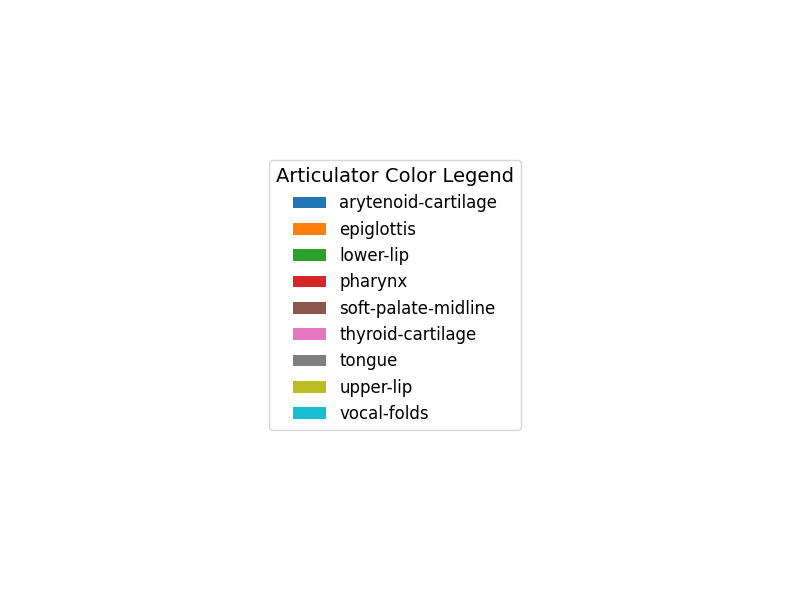


Dataset Information:
Subject: ArtSpeech_Vocal_Tract_Segmentation/1612
Sequence: S10
Total images in sequence: 18
Images with annotations: 6
Number of articulator classes: 9


In [22]:
# Create a legend showing which color corresponds to which articulator
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')

# Display color legend
legend_elements = []
for i, class_name in enumerate(classes):
    color = colors[i][:3]
    legend_elements.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=class_name))

ax.legend(handles=legend_elements, loc='center', fontsize=12, 
          title='Articulator Color Legend', title_fontsize=14)
plt.tight_layout()
plt.show()

print("\nDataset Information:")
print(f"Subject: {SUBJECT}")
print(f"Sequence: {SEQUENCE}")
print(f"Total images in sequence: {len(dicom_files)}")
print(f"Images with annotations: {len(frame_ids_with_masks)}")
print(f"Number of articulator classes: {len(classes)}")

In [23]:
# Import Ultralytics SAM
from ultralytics import SAM

# Initialize SAM 2.1 model (latest version, it will auto-download if not present)
# Available models: sam2.1_t.pt (tiny), sam2.1_s.pt (small), sam2.1_b.pt (base), sam2.1_l.pt (large)
# Also available: sam2_t.pt, sam2_s.pt, sam2_b.pt, sam2_l.pt (SAM 2.0)
model = SAM("sam2.1_l.pt")  # Using SAM 2.1 large model for best accuracy

print("SAM 2.1 model loaded successfully!")
print(f"Model loaded: SAM 2.1 Large")

SAM 2.1 model loaded successfully!
Model loaded: SAM 2.1 Large


# SAM v2 Zero-Shot Segmentation for Articulators

SAM v2 (Segment Anything Model version 2) supports multiple prompting modes:
1. **Point prompts**: Click on objects to segment
2. **Box prompts**: Draw bounding boxes around objects
3. **Text prompts**: Describe what to segment (with CLIP integration)
4. **Mask prompts**: Provide rough masks to refine

In [24]:
# Helper function to get approximate regions for articulators from ground truth
# (for demonstration, we'll use ground truth boxes as prompts)
def get_articulator_prompts_from_gt(masks_dict, articulator_names):
    """
    Extract point prompts or box prompts from ground truth masks.
    In real zero-shot scenario, these would come from user interaction or heuristics.
    """
    prompts = {}
    
    for art_name in articulator_names:
        if art_name in masks_dict:
            mask = masks_dict[art_name]
            # Get bounding box from mask
            rows = np.any(mask, axis=1)
            cols = np.any(mask, axis=0)
            
            if rows.any() and cols.any():
                rmin, rmax = np.where(rows)[0][[0, -1]]
                cmin, cmax = np.where(cols)[0][[0, -1]]
                
                # Store as [x1, y1, x2, y2]
                prompts[art_name] = {
                    'box': [cmin, rmin, cmax, rmax],
                    'center_point': [(cmin + cmax) // 2, (rmin + rmax) // 2]
                }
    
    return prompts


In [25]:
# Apply SAM 2.1 for zero-shot segmentation on a sample image
# Let's use the first annotated frame
sample_frame_id = frame_ids_with_masks[0]

# Load the image
dicom_path = os.path.join(dicoms_path, f"{sample_frame_id}.dcm")
dcm = pydicom.dcmread(dicom_path)
img_array = dcm.pixel_array

# Normalize to 0-255 and convert to RGB (SAM expects 3-channel input)
img_normalized = ((img_array - img_array.min()) / (img_array.max() - img_array.min()) * 255).astype(np.uint8)
img_rgb = np.stack([img_normalized, img_normalized, img_normalized], axis=-1)

# Load ground truth masks
gt_masks_dict = {}
for class_name in classes:
    mask_file = os.path.join(masks_path, f"{sample_frame_id}_{class_name}.png")
    if os.path.exists(mask_file):
        mask = Image.open(mask_file).convert('L')
        gt_masks_dict[class_name] = np.array(mask) > 0

print(f"Processing frame {sample_frame_id}")
print(f"Image shape: {img_rgb.shape}")
print(f"Ground truth articulators: {list(gt_masks_dict.keys())}")

Processing frame 0013
Image shape: (136, 136, 3)
Ground truth articulators: ['arytenoid-cartilage', 'epiglottis', 'lower-lip', 'pharynx', 'soft-palate-midline', 'thyroid-cartilage', 'tongue', 'upper-lip', 'vocal-folds']


In [26]:
# Get prompts from ground truth (simulating user interaction)
prompts = get_articulator_prompts_from_gt(gt_masks_dict, classes)
prompts

{'arytenoid-cartilage': {'box': [77, 92, 83, 116], 'center_point': [80, 104]},
 'epiglottis': {'box': [61, 78, 69, 102], 'center_point': [65, 90]},
 'lower-lip': {'box': [16, 57, 29, 73], 'center_point': [22, 65]},
 'pharynx': {'box': [70, 37, 82, 95], 'center_point': [76, 66]},
 'soft-palate-midline': {'box': [53, 45, 68, 59], 'center_point': [60, 52]},
 'thyroid-cartilage': {'box': [57, 102, 65, 110], 'center_point': [61, 106]},
 'tongue': {'box': [26, 45, 67, 91], 'center_point': [46, 68]},
 'upper-lip': {'box': [15, 41, 27, 56], 'center_point': [21, 48]},
 'vocal-folds': {'box': [64, 100, 77, 107], 'center_point': [70, 103]}}


0: 1024x1024 (no detections), 8595.5ms
Speed: 4.8ms preprocess, 8595.5ms inference, 0.1ms postprocess per image at shape (1, 3, 1024, 1024)
0: 1024x1024 (no detections), 8595.5ms
Speed: 4.8ms preprocess, 8595.5ms inference, 0.1ms postprocess per image at shape (1, 3, 1024, 1024)


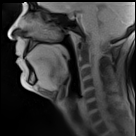

In [27]:
results = model(img_rgb)  # image

results[0].show()  # Display results

In [28]:
# Apply SAM v2 ith box prompts for each articulator
sam_predictions = {}

print("Running SAM v2 predictions...")
for art_name, prompt_info in prompts.items():
    box = prompt_info['box']
    
    # Run SAM prediction with box prompt
    # Format: bboxes parameter expects [[x1, y1, x2, y2]]
    results = model(img_rgb, bboxes=[box], verbose=False)
    
    # Extract the predicted mask
    if len(results) > 0 and results[0].masks is not None:
        predicted_mask = results[0].masks.data[0].cpu().numpy()
        sam_predictions[art_name] = predicted_mask > 0.5
        print(f"✓ {art_name}: Predicted mask shape {predicted_mask.shape}")
    else:
        sam_predictions[art_name] = None
        print(f"✗ {art_name}: No mask predicted")

print(f"\nSuccessfully predicted {len([m for m in sam_predictions.values() if m is not None])} out of {len(prompts)} articulators")

Running SAM v2 predictions...
✓ arytenoid-cartilage: Predicted mask shape (136, 136)
✓ arytenoid-cartilage: Predicted mask shape (136, 136)
✓ epiglottis: Predicted mask shape (136, 136)
✓ epiglottis: Predicted mask shape (136, 136)
✓ lower-lip: Predicted mask shape (136, 136)
✓ lower-lip: Predicted mask shape (136, 136)
✓ pharynx: Predicted mask shape (136, 136)
✓ pharynx: Predicted mask shape (136, 136)
✓ soft-palate-midline: Predicted mask shape (136, 136)
✓ soft-palate-midline: Predicted mask shape (136, 136)
✓ thyroid-cartilage: Predicted mask shape (136, 136)
✓ thyroid-cartilage: Predicted mask shape (136, 136)
✓ tongue: Predicted mask shape (136, 136)
✓ tongue: Predicted mask shape (136, 136)
✓ upper-lip: Predicted mask shape (136, 136)
✓ upper-lip: Predicted mask shape (136, 136)
✓ vocal-folds: Predicted mask shape (136, 136)

Successfully predicted 9 out of 9 articulators
✓ vocal-folds: Predicted mask shape (136, 136)

Successfully predicted 9 out of 9 articulators


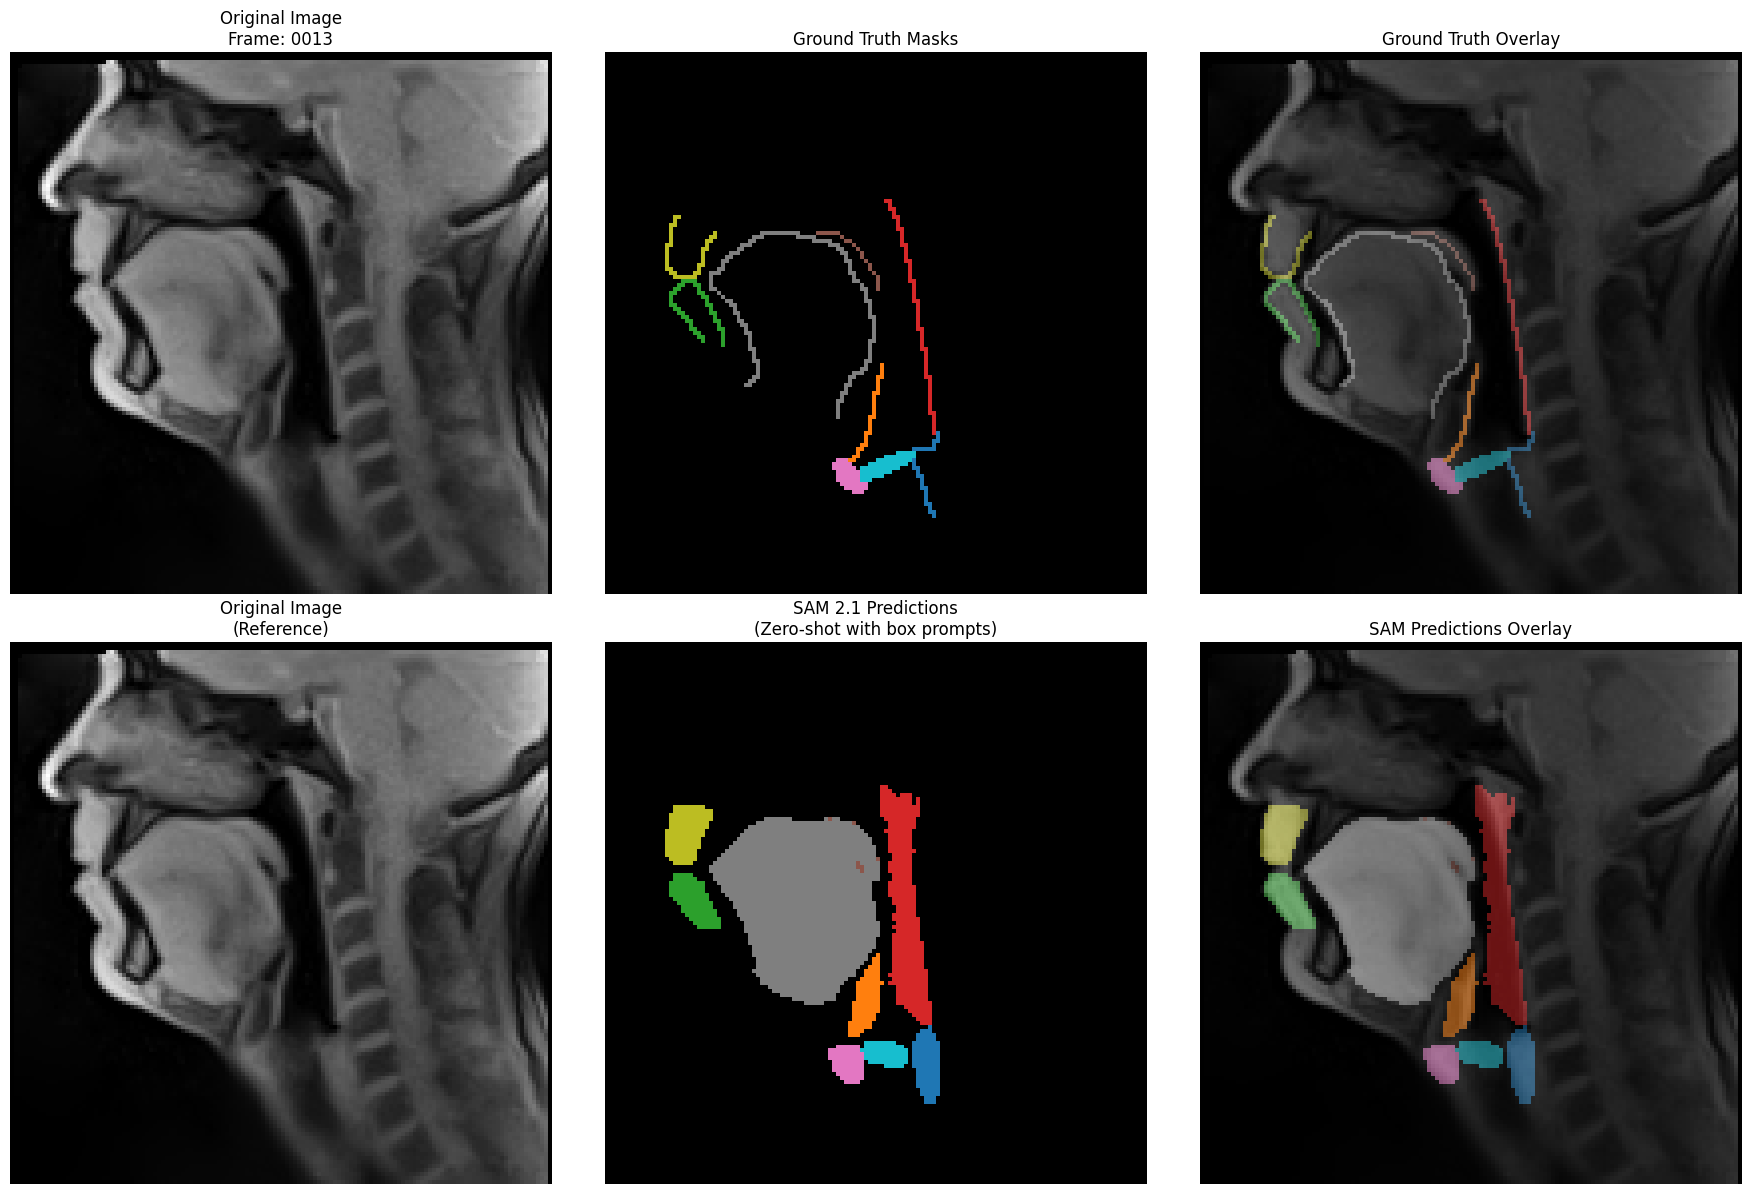


Comparison: SAM 2.1 Zero-Shot vs Ground Truth


In [29]:
# Visualize SAM predictions vs Ground Truth
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Create combined masks for visualization
gt_combined = np.zeros((*img_array.shape, 3))
sam_combined = np.zeros((*img_array.shape, 3))

for i, class_name in enumerate(classes):
    if class_name in gt_masks_dict:
        gt_combined[gt_masks_dict[class_name]] = colors[i][:3]
    
    if class_name in sam_predictions and sam_predictions[class_name] is not None:
        sam_combined[sam_predictions[class_name]] = colors[i][:3]

# Row 1: Ground Truth
axes[0, 0].imshow(img_normalized, cmap='gray')
axes[0, 0].set_title(f'Original Image\nFrame: {sample_frame_id}', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(gt_combined)
axes[0, 1].set_title('Ground Truth Masks', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(img_normalized, cmap='gray')
axes[0, 2].imshow(gt_combined, alpha=0.5)
axes[0, 2].set_title('Ground Truth Overlay', fontsize=12)
axes[0, 2].axis('off')

# Row 2: SAM Predictions
axes[1, 0].imshow(img_normalized, cmap='gray')
axes[1, 0].set_title('Original Image\n(Reference)', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(sam_combined)
axes[1, 1].set_title('SAM 2.1 Predictions\n(Zero-shot with box prompts)', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(img_normalized, cmap='gray')
axes[1, 2].imshow(sam_combined, alpha=0.5)
axes[1, 2].set_title('SAM Predictions Overlay', fontsize=12)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\nComparison: SAM 2.1 Zero-Shot vs Ground Truth")
print("=" * 60)

In [30]:
# Calculate IoU (Intersection over Union) for each articulator
def calculate_iou(pred_mask, gt_mask):
    """Calculate Intersection over Union between predicted and ground truth masks."""
    if pred_mask is None or gt_mask is None:
        return 0.0
    
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    
    if union == 0:
        return 0.0
    
    return intersection / union

# Calculate IoU for each articulator
print("IoU Scores (SAM 2.1 Zero-Shot vs Ground Truth):")
print("=" * 60)
iou_scores = {}

for art_name in classes:
    if art_name in gt_masks_dict and art_name in sam_predictions:
        gt_mask = gt_masks_dict[art_name]
        pred_mask = sam_predictions[art_name]
        
        iou = calculate_iou(pred_mask, gt_mask)
        iou_scores[art_name] = iou
        print(f"{art_name:25s}: {iou:.4f} ({iou*100:.2f}%)")

if iou_scores:
    mean_iou = np.mean(list(iou_scores.values()))
    print("=" * 60)
    print(f"{'Mean IoU':25s}: {mean_iou:.4f} ({mean_iou*100:.2f}%)")
else:
    print("No IoU scores calculated")

IoU Scores (SAM 2.1 Zero-Shot vs Ground Truth):
arytenoid-cartilage      : 0.2269 (22.69%)
epiglottis               : 0.1610 (16.10%)
lower-lip                : 0.2406 (24.06%)
pharynx                  : 0.0684 (6.84%)
soft-palate-midline      : 0.1624 (16.24%)
thyroid-cartilage        : 0.6104 (61.04%)
tongue                   : 0.0881 (8.81%)
upper-lip                : 0.1132 (11.32%)
vocal-folds              : 0.4318 (43.18%)
Mean IoU                 : 0.2336 (23.36%)


##  Point-Based Prompting

Instead of using bounding boxes, we can use point prompts

In [31]:
# Use point prompts instead of boxes
sam_point_predictions = {}

print("Running SAM 2.1 predictions with point prompts...")
for art_name, prompt_info in prompts.items():
    point = prompt_info['center_point']
    
    # Run SAM prediction with point prompt
    # Format: points parameter expects [[x, y]]
    results = model(img_rgb, points=[point], labels=[1], verbose=False)
    
    # Extract the predicted mask
    if len(results) > 0 and results[0].masks is not None and len(results[0].masks.data) > 0:
        predicted_mask = results[0].masks.data[0].cpu().numpy()
        sam_point_predictions[art_name] = predicted_mask > 0.5
        print(f"✓ {art_name}: Predicted mask shape {predicted_mask.shape}")
    else:
        sam_point_predictions[art_name] = None
        print(f"✗ {art_name}: No mask predicted")

print(f"\nSuccessfully predicted {len([m for m in sam_point_predictions.values() if m is not None])} out of {len(prompts)} articulators")

# Calculate IoU for point-based predictions
print("\n" + "=" * 60)
print("IoU Scores (Point Prompts vs Ground Truth):")
print("=" * 60)
point_iou_scores = {}

for art_name in classes:
    if art_name in gt_masks_dict and art_name in sam_point_predictions and sam_point_predictions[art_name] is not None:
        gt_mask = gt_masks_dict[art_name]
        pred_mask = sam_point_predictions[art_name]
        
        iou = calculate_iou(pred_mask, gt_mask)
        point_iou_scores[art_name] = iou
        print(f"{art_name:25s}: {iou:.4f} ({iou*100:.2f}%)")

if point_iou_scores:
    mean_iou_point = np.mean(list(point_iou_scores.values()))
    print("=" * 60)
    print(f"{'Mean IoU (Point)':25s}: {mean_iou_point:.4f} ({mean_iou_point*100:.2f}%)")
    if iou_scores:
        print(f"{'Mean IoU (Box)':25s}: {mean_iou:.4f} ({mean_iou*100:.2f}%)")
        print(f"{'Difference (Box - Point)':25s}: {(mean_iou - mean_iou_point):.4f}")

Running SAM 2.1 predictions with point prompts...


✓ arytenoid-cartilage: Predicted mask shape (136, 136)
✗ epiglottis: No mask predicted
✗ epiglottis: No mask predicted
✓ lower-lip: Predicted mask shape (136, 136)
✓ lower-lip: Predicted mask shape (136, 136)
✓ pharynx: Predicted mask shape (136, 136)
✓ pharynx: Predicted mask shape (136, 136)
✓ soft-palate-midline: Predicted mask shape (136, 136)
✓ soft-palate-midline: Predicted mask shape (136, 136)
✓ thyroid-cartilage: Predicted mask shape (136, 136)
✓ thyroid-cartilage: Predicted mask shape (136, 136)
✓ tongue: Predicted mask shape (136, 136)
✓ tongue: Predicted mask shape (136, 136)
✗ upper-lip: No mask predicted
✗ upper-lip: No mask predicted
✓ vocal-folds: Predicted mask shape (136, 136)

Successfully predicted 7 out of 9 articulators

IoU Scores (Point Prompts vs Ground Truth):
arytenoid-cartilage      : 0.0031 (0.31%)
lower-lip                : 0.0227 (2.27%)
pharynx                  : 0.0000 (0.00%)
soft-palate-midline      : 0.0049 (0.49%)
thyroid-cartilage        : 0.0627 (

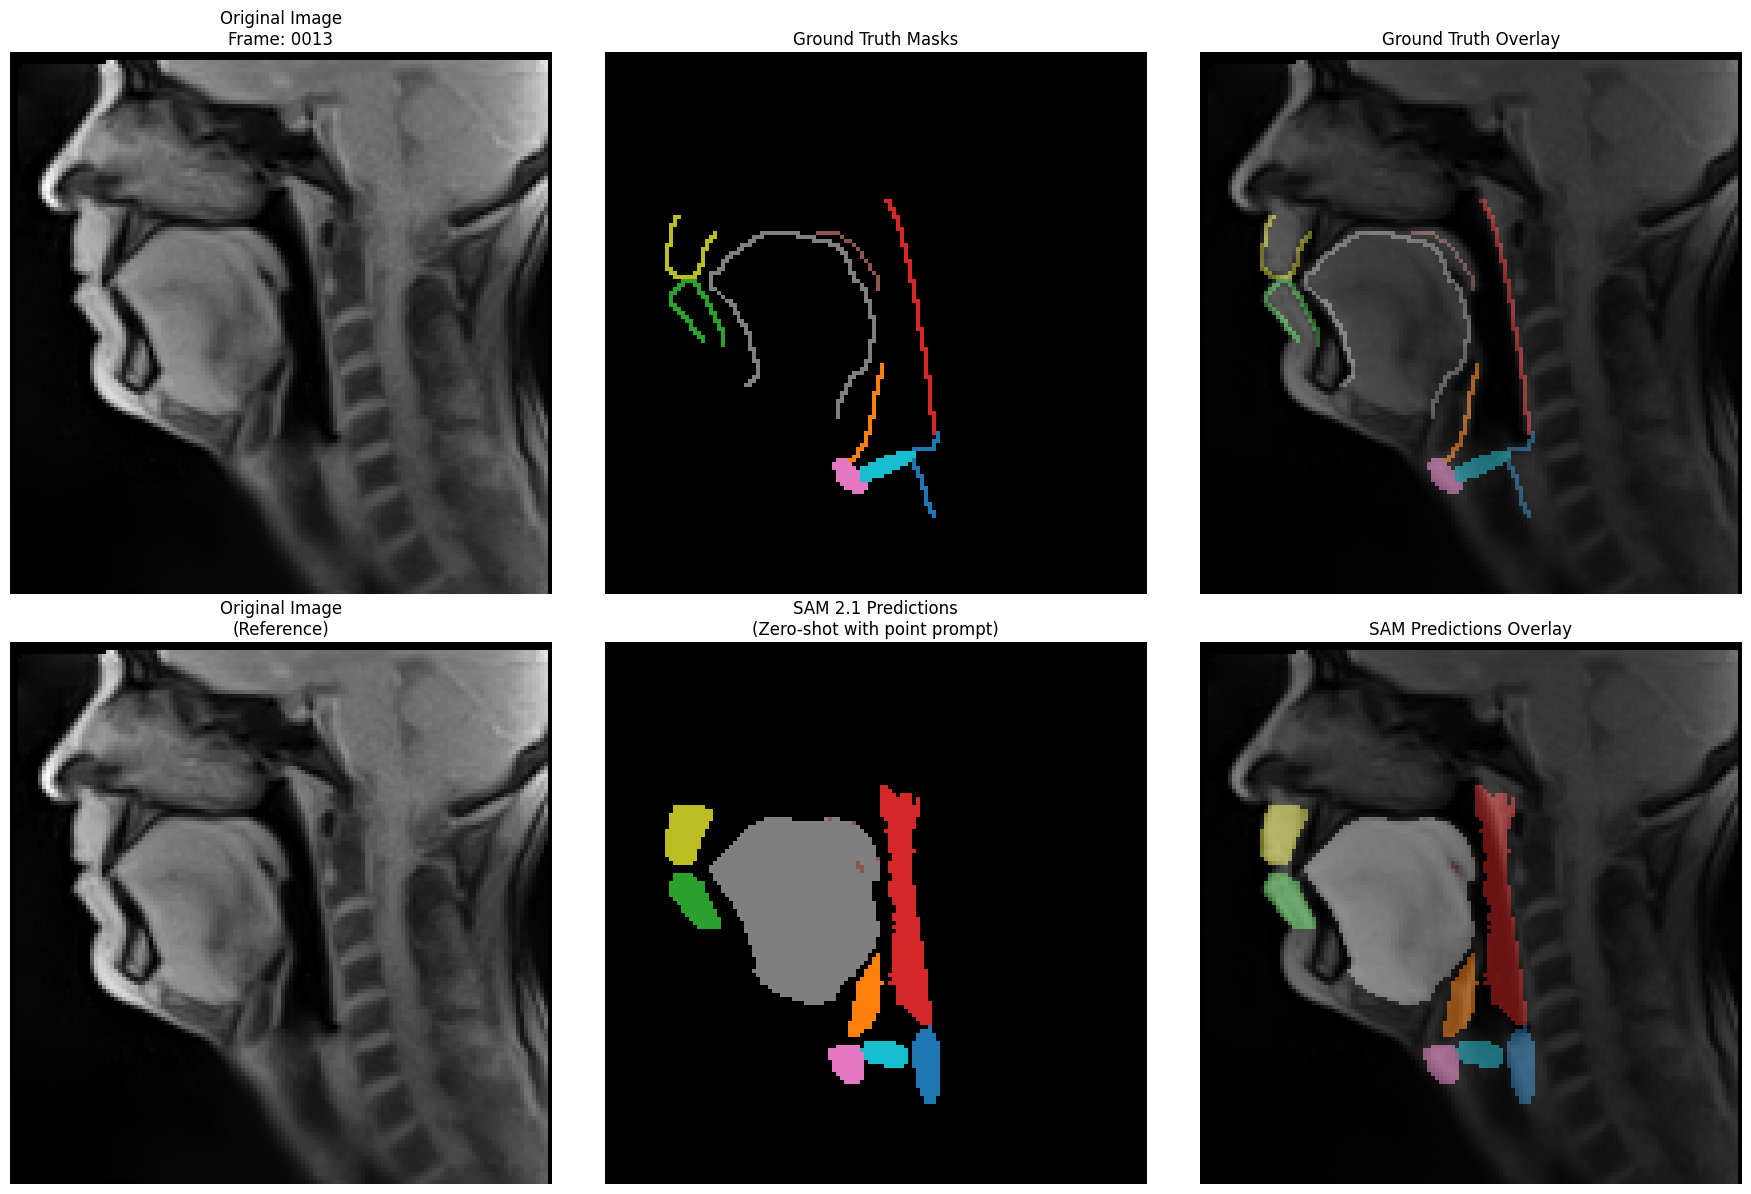


Comparison: SAM 2.1 Zero-Shot vs Ground Truth


In [32]:
# Visualize SAM predictions vs Ground Truth
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Create combined masks for visualization
gt_combined = np.zeros((*img_array.shape, 3))
sam_combined = np.zeros((*img_array.shape, 3))

for i, class_name in enumerate(classes):
    if class_name in gt_masks_dict:
        gt_combined[gt_masks_dict[class_name]] = colors[i][:3]
    
    if class_name in sam_predictions and sam_predictions[class_name] is not None:
        sam_combined[sam_predictions[class_name]] = colors[i][:3]

# Row 1: Ground Truth
axes[0, 0].imshow(img_normalized, cmap='gray')
axes[0, 0].set_title(f'Original Image\nFrame: {sample_frame_id}', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(gt_combined)
axes[0, 1].set_title('Ground Truth Masks', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(img_normalized, cmap='gray')
axes[0, 2].imshow(gt_combined, alpha=0.5)
axes[0, 2].set_title('Ground Truth Overlay', fontsize=12)
axes[0, 2].axis('off')

# Row 2: SAM Predictions
axes[1, 0].imshow(img_normalized, cmap='gray')
axes[1, 0].set_title('Original Image\n(Reference)', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(sam_combined)
axes[1, 1].set_title('SAM 2.1 Predictions\n(Zero-shot with point prompt)', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(img_normalized, cmap='gray')
axes[1, 2].imshow(sam_combined, alpha=0.5)
axes[1, 2].set_title('SAM Predictions Overlay', fontsize=12)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\nComparison: SAM 2.1 Zero-Shot vs Ground Truth")
print("=" * 60)

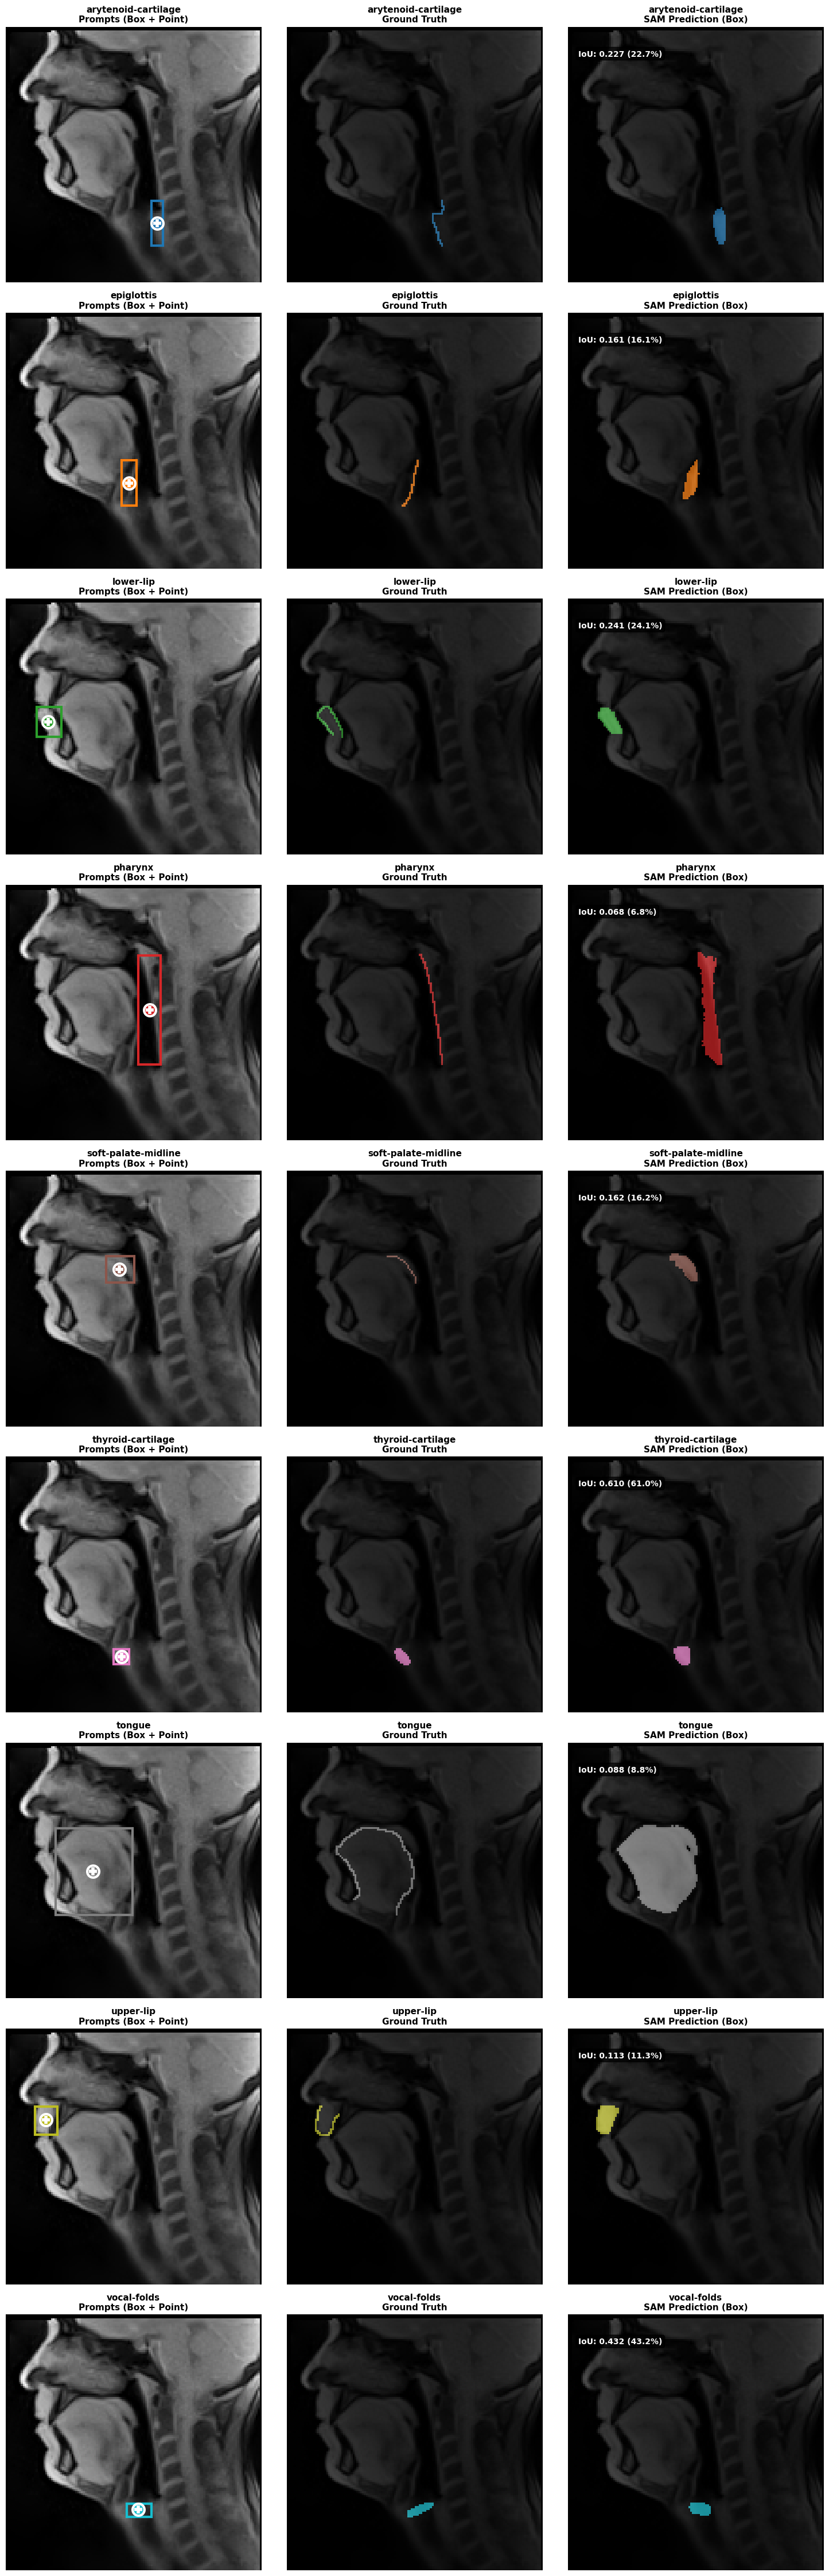


INDIVIDUAL ARTICULATOR ANALYSIS
Each row shows a different articulator:
  - Left: Original image with box (rectangle) and point (circle+cross) prompts
  - Middle: Ground truth segmentation mask
  - Right: SAM prediction with IoU score


In [34]:
import matplotlib.patches as patches

# Create individual visualizations for each articulator
# This shows the prompt, ground truth, and SAM prediction for each articulator separately

num_articulators = len(prompts)
n_cols = 3  # Original+Prompt, Ground Truth, SAM Prediction
n_rows = num_articulators

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

for idx, (art_name, prompt_info) in enumerate(prompts.items()):
    row_idx = idx
    
    # Get color for this articulator
    color_idx = classes.index(art_name)
    art_color = colors[color_idx][:3]
    
    # Column 1: Original image with prompt (box and point)
    axes[row_idx, 0].imshow(img_normalized, cmap='gray')
    
    # Draw box
    box = prompt_info['box']
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=3, edgecolor=art_color, facecolor='none')
    axes[row_idx, 0].add_patch(rect)
    
    # Draw point
    point = prompt_info['center_point']
    axes[row_idx, 0].plot(point[0], point[1], 'o', color=art_color, markersize=15, 
                         markeredgecolor='white', markeredgewidth=3)
    axes[row_idx, 0].plot(point[0], point[1], '+', color='white', markersize=10, markeredgewidth=4)
    
    axes[row_idx, 0].set_title(f'{art_name}\nPrompts (Box + Point)', fontsize=11, fontweight='bold')
    axes[row_idx, 0].axis('off')
    
    # Column 2: Ground Truth
    axes[row_idx, 1].imshow(img_normalized, cmap='gray')
    if art_name in gt_masks_dict:
        gt_mask_colored = np.zeros((*img_array.shape, 3))
        gt_mask_colored[gt_masks_dict[art_name]] = art_color
        axes[row_idx, 1].imshow(gt_mask_colored, alpha=0.7)
    axes[row_idx, 1].set_title(f'{art_name}\nGround Truth', fontsize=11, fontweight='bold')
    axes[row_idx, 1].axis('off')
    
    # Column 3: SAM Prediction (Box)
    axes[row_idx, 2].imshow(img_normalized, cmap='gray')
    if art_name in sam_predictions and sam_predictions[art_name] is not None:
        sam_mask_colored = np.zeros((*img_array.shape, 3))
        sam_mask_colored[sam_predictions[art_name]] = art_color
        axes[row_idx, 2].imshow(sam_mask_colored, alpha=0.7)
        
        # Add IoU score
        if art_name in iou_scores:
            iou_text = f'IoU: {iou_scores[art_name]:.3f} ({iou_scores[art_name]*100:.1f}%)'
            axes[row_idx, 2].text(5, 15, iou_text, color='white', fontsize=10, 
                                 bbox=dict(boxstyle='round', facecolor='black', alpha=0.7),
                                 fontweight='bold')
    axes[row_idx, 2].set_title(f'{art_name}\nSAM Prediction (Box)', fontsize=11, fontweight='bold')
    axes[row_idx, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("INDIVIDUAL ARTICULATOR ANALYSIS")
print("=" * 80)
print("Each row shows a different articulator:")
print("  - Left: Original image with box (rectangle) and point (circle+cross) prompts")
print("  - Middle: Ground truth segmentation mask")
print("  - Right: SAM prediction with IoU score")
print("=" * 80)

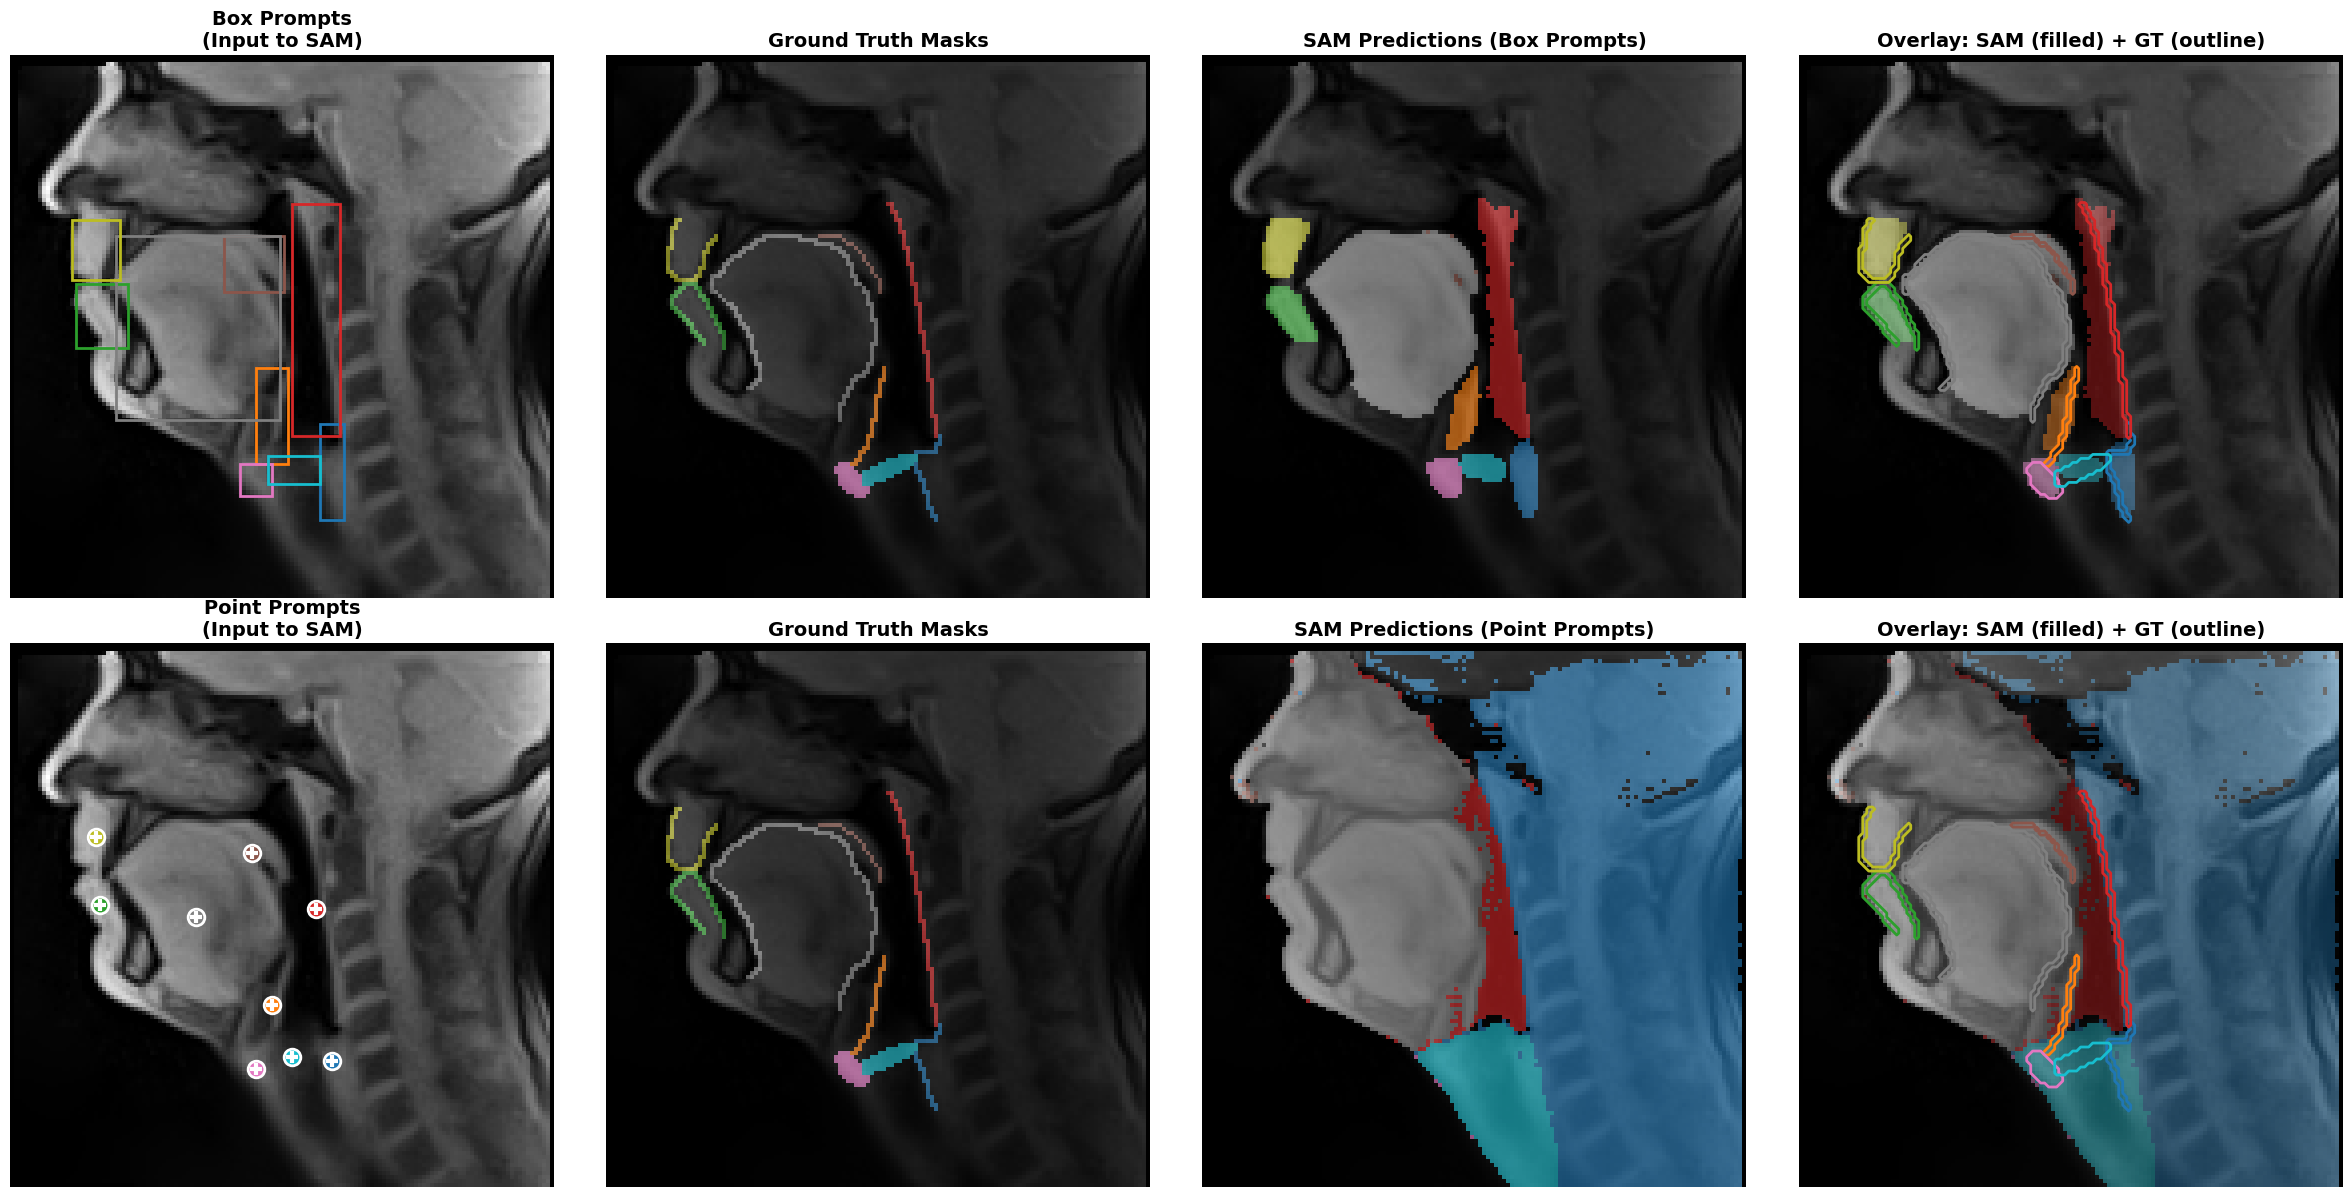

In [35]:
# Create comprehensive visualization with prompts
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

# Row 1: Box Prompts
# Column 1: Original with box prompts
axes[0, 0].imshow(img_normalized, cmap='gray')
for i, (art_name, prompt_info) in enumerate(prompts.items()):
    box = prompt_info['box']  # [x1, y1, x2, y2]
    color = colors[i][:3]
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=2, edgecolor=color, facecolor='none', label=art_name)
    axes[0, 0].add_patch(rect)
axes[0, 0].set_title('Box Prompts\n(Input to SAM)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Column 2: Ground Truth
axes[0, 1].imshow(img_normalized, cmap='gray')
gt_combined = np.zeros((*img_array.shape, 3))
for i, class_name in enumerate(classes):
    if class_name in gt_masks_dict:
        gt_combined[gt_masks_dict[class_name]] = colors[i][:3]
axes[0, 1].imshow(gt_combined, alpha=0.6)
axes[0, 1].set_title('Ground Truth Masks', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Column 3: SAM Box Predictions
axes[0, 2].imshow(img_normalized, cmap='gray')
sam_box_combined = np.zeros((*img_array.shape, 3))
for i, class_name in enumerate(classes):
    if class_name in sam_predictions and sam_predictions[class_name] is not None:
        sam_box_combined[sam_predictions[class_name]] = colors[i][:3]
axes[0, 2].imshow(sam_box_combined, alpha=0.6)
axes[0, 2].set_title('SAM Predictions (Box Prompts)', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Column 4: Comparison (GT outline + SAM fill)
axes[0, 3].imshow(img_normalized, cmap='gray')
axes[0, 3].imshow(sam_box_combined, alpha=0.4)
# Add GT as contours
for i, class_name in enumerate(classes):
    if class_name in gt_masks_dict:
        axes[0, 3].contour(gt_masks_dict[class_name], colors=[colors[i][:3]], linewidths=2)
axes[0, 3].set_title('Overlay: SAM (filled) + GT (outline)', fontsize=14, fontweight='bold')
axes[0, 3].axis('off')

# Row 2: Point Prompts
# Column 1: Original with point prompts
axes[1, 0].imshow(img_normalized, cmap='gray')
for i, (art_name, prompt_info) in enumerate(prompts.items()):
    point = prompt_info['center_point']  # [x, y]
    color = colors[i][:3]
    axes[1, 0].plot(point[0], point[1], 'o', color=color, markersize=12, 
                   markeredgecolor='white', markeredgewidth=2, label=art_name)
    axes[1, 0].plot(point[0], point[1], '+', color='white', markersize=8, markeredgewidth=3)
axes[1, 0].set_title('Point Prompts\n(Input to SAM)', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# Column 2: Ground Truth (same as above)
axes[1, 1].imshow(img_normalized, cmap='gray')
axes[1, 1].imshow(gt_combined, alpha=0.6)
axes[1, 1].set_title('Ground Truth Masks', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

# Column 3: SAM Point Predictions
axes[1, 2].imshow(img_normalized, cmap='gray')
sam_point_combined = np.zeros((*img_array.shape, 3))
for i, class_name in enumerate(classes):
    if class_name in sam_point_predictions and sam_point_predictions[class_name] is not None:
        sam_point_combined[sam_point_predictions[class_name]] = colors[i][:3]
axes[1, 2].imshow(sam_point_combined, alpha=0.6)
axes[1, 2].set_title('SAM Predictions (Point Prompts)', fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

# Column 4: Comparison (GT outline + SAM fill)
axes[1, 3].imshow(img_normalized, cmap='gray')
axes[1, 3].imshow(sam_point_combined, alpha=0.4)
# Add GT as contours
for i, class_name in enumerate(classes):
    if class_name in gt_masks_dict:
        axes[1, 3].contour(gt_masks_dict[class_name], colors=[colors[i][:3]], linewidths=2)
axes[1, 3].set_title('Overlay: SAM (filled) + GT (outline)', fontsize=14, fontweight='bold')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()



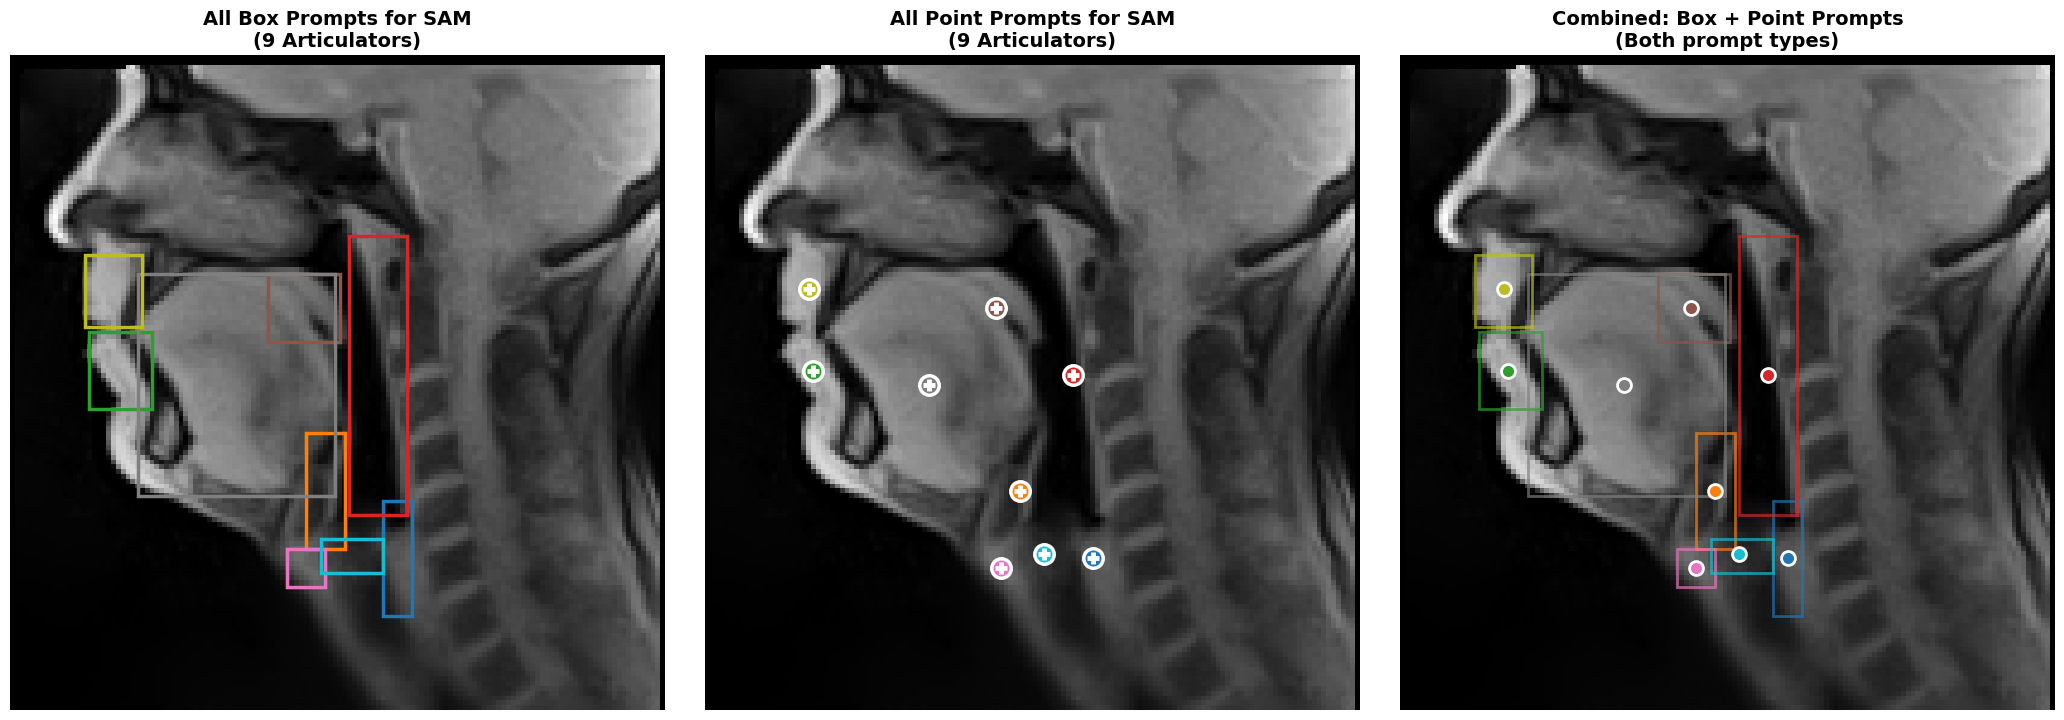


PROMPT VISUALIZATION WITH IoU SCORES
  arytenoid-cartilage       - IoU:  0.227 ( 22.7%)
  epiglottis                - IoU:  0.161 ( 16.1%)
  lower-lip                 - IoU:  0.241 ( 24.1%)
  pharynx                   - IoU:  0.068 (  6.8%)
  soft-palate-midline       - IoU:  0.162 ( 16.2%)
  thyroid-cartilage         - IoU:  0.610 ( 61.0%)
  tongue                    - IoU:  0.088 (  8.8%)
  upper-lip                 - IoU:  0.113 ( 11.3%)
  vocal-folds               - IoU:  0.432 ( 43.2%)
  Mean IoU (Box prompts)    - 0.234 (23.4%)
  Mean IoU (Point prompts)  - 0.028 (2.8%)


In [36]:
# Create a comprehensive single-image view showing all prompts
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# Image 1: All Box Prompts
axes[0].imshow(img_normalized, cmap='gray')
for i, (art_name, prompt_info) in enumerate(prompts.items()):
    box = prompt_info['box']
    color = colors[i][:3]
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=2.5, edgecolor=color, facecolor='none')
    axes[0].add_patch(rect)
axes[0].set_title('All Box Prompts for SAM\n(9 Articulators)', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Image 2: All Point Prompts
axes[1].imshow(img_normalized, cmap='gray')
for i, (art_name, prompt_info) in enumerate(prompts.items()):
    point = prompt_info['center_point']
    color = colors[i][:3]
    axes[1].plot(point[0], point[1], 'o', color=color, markersize=14, 
                markeredgecolor='white', markeredgewidth=2.5)
    axes[1].plot(point[0], point[1], '+', color='white', markersize=9, markeredgewidth=3.5)
axes[1].set_title('All Point Prompts for SAM\n(9 Articulators)', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Image 3: Both prompts together
axes[2].imshow(img_normalized, cmap='gray')
for i, (art_name, prompt_info) in enumerate(prompts.items()):
    box = prompt_info['box']
    point = prompt_info['center_point']
    color = colors[i][:3]
    
    # Draw box
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=2, edgecolor=color, facecolor='none', alpha=0.7)
    axes[2].add_patch(rect)
    
    # Draw point
    axes[2].plot(point[0], point[1], 'o', color=color, markersize=10, 
                markeredgecolor='white', markeredgewidth=2)
axes[2].set_title('Combined: Box + Point Prompts\n(Both prompt types)', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Add legend with IoU scores
print("\n" + "=" * 80)
print("PROMPT VISUALIZATION WITH IoU SCORES")
print("=" * 80)
for i, art_name in enumerate(classes):
    color_idx = i
    if art_name in iou_scores:
        print(f"  {art_name:25s} - IoU: {iou_scores[art_name]:6.3f} ({iou_scores[art_name]*100:5.1f}%)")
    else:
        print(f"  {art_name:25s} - IoU: N/A")
print("=" * 80)
print(f"  {'Mean IoU (Box prompts)':25s} - {mean_iou:.3f} ({mean_iou*100:.1f}%)")
if 'mean_iou_point' in locals():
    print(f"  {'Mean IoU (Point prompts)':25s} - {mean_iou_point:.3f} ({mean_iou_point*100:.1f}%)")
print("=" * 80)

In [37]:
Text_prompt ="Segment this mid-sagittal RT-MRI vocal-tract frame into nine separate masks, one per class: arytenoid-cartilage, epiglottis, lower-lip, pharynx, soft-palate-midline, thyroid-cartilage, tongue, upper-lip, and vocal-folds. Assume anterior/face is on the left, posterior/spine on the right, superior up, inferior down; airspaces are darkest/black and air–tissue interfaces are the most reliable boundaries. Perform segmentation one structure at a time (nine passes) and treat each “prompt” as a tight bounding box plus a set of positive points on the target and negative points in adjacent air and on confusing neighboring boundaries. For every structure, begin with a tight box enclosing only the expected anatomy, place 3–7 positive clicks along the structure’s boundary (include endpoints and curvature changes), then place 3–15 negative clicks inside nearby dark airspaces where leakage occurs and directly on the closest neighboring structure that could steal the mask; iterate by adding negatives inside any wrongly included area (especially dark airway) when the mask over-expands, or adding positives along missing segments when the mask under-segments. Upper-lip: isolate only the superior lip tissue forming the upper boundary of the mouth opening at the anterior edge; exclude the nose/cheek facial outline and oral air behind the lip by placing negatives on facial skin boundary above the lip and inside the dark oral cavity if it floods inward. Lower-lip: isolate only the inferior lip tissue forming the lower boundary of the mouth opening; exclude chin/mandible and outside background by placing negatives along the chin/jaw skin boundary and in outside air below/anterior to the lip, and negatives in oral air if the mask fills the mouth. Tongue: segment the tongue body (or at minimum its dorsum boundary) occupying the oral cavity from anterior tongue behind the lips/teeth region to the posterior tongue root; prevent “fill-the-mouth” behavior by placing many negatives in the dark oral air above the tongue dorsum, additional negatives in the dark pharyngeal airway posteriorly, and negatives on the soft palate if it merges superiorly; place positives along anterior tongue, mid-dorsum curvature, and tongue root. Soft-palate-midline: segment the velum/soft palate midline region posterior to the hard palate and superior to the posterior tongue, forming the separation between oral and nasopharyngeal spaces; avoid merging with the tongue by placing negatives on tongue immediately below, and avoid snapping to the long pharyngeal boundary by placing negatives on the pharyngeal wall if needed; place positives on anterior attachment, mid-curve, and posterior end of the velum. Pharynx: segment only the pharyngeal airway boundary (posterior pharyngeal wall) facing the dark pharyngeal air column, not the posterior neck/spine edge; place positives spaced from superior to inferior along the airway-facing wall, place multiple negatives inside the dark pharyngeal lumen adjacent to the wall to prevent flood-fill, and place negatives along vertebra/spine boundaries to prevent snapping posteriorly. Epiglottis: segment the epiglottis as a small leaf-like structure posterior to tongue base and superior to the laryngeal inlet; use a very tight box, place positives on visible epiglottis ridge (tip/upper, mid-body, base), and place negatives in the adjacent airway behind/below it, on the tongue root anteriorly, and on the pharyngeal wall posteriorly to prevent leakage. Thyroid-cartilage: segment the anterior laryngeal framework surrounding the upper airway, typically anterior to the dark laryngeal/tracheal air column and inferior to the tongue base/epiglottis; keep the box tight around the anterior cartilage contour, place positives on superior/mid/inferior portions of the cartilage boundary, and place negatives inside the dark airway immediately posterior to it plus negatives on nearby soft tissues if it expands outward; prevent merging with vocal-folds by adding negatives on the glottic region when necessary. Vocal-folds: segment the small glottic/vocal-fold region within the larynx (inferior to epiglottis, posterior to thyroid cartilage, anterior to arytenoids); use the tightest box of all classes, place clustered positives strictly on the vocal-fold ridge/region (center and ends), and place many negatives inside the dark airway above and below to stop airway column flood-fill; also add negatives on thyroid cartilage anteriorly and arytenoid region posteriorly to keep separation. Arytenoid-cartilage: segment the posterior laryngeal arytenoid structures just posterior to the vocal-fold region and near the transition toward the pharynx; use a tight box that avoids including the long pharyngeal wall, place positives on the arytenoid silhouette, and place strong negatives on the pharyngeal wall boundary (a frequent confuser), plus negatives inside adjacent airway lumen and on the vocal-fold region anteriorly if masks merge. Output nine masks aligned to the frame; prefer masks that are anatomically local and conservative in low-contrast laryngeal regions (vocal folds, arytenoids, thyroid cartilage), then refine with additional positive clicks on missing segments and negative clicks directly inside any leaked airspace or neighboring structure."

## Multi-Point Prompting Strategy

we can implement the strategy described above using:
- **Positive points**: Click on the target structure boundaries
- **Negative points**: Click on adjacent air spaces and confusing neighboring structures
- **Tight bounding boxes**: Enclose only the expected anatomy


In [38]:
# Helper function to generate multiple positive and negative points for each articulator
def get_multipoint_prompts(masks_dict, img_shape):
    """
    Generate positive and negative points for each articulator based on the text prompt strategy.
    - Positive points: Along the boundary of the target structure
    - Negative points: In adjacent airspaces and neighboring structures
    """
    multipoint_prompts = {}
    h, w = img_shape
    
    for art_name, mask in masks_dict.items():
        if mask is None:
            continue
            
        # Get bounding box
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)
        
        if not rows.any() or not cols.any():
            continue
            
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        
        # Generate positive points along the mask boundary
        # Find boundary pixels
        from scipy.ndimage import binary_erosion
        eroded = binary_erosion(mask)
        boundary = mask & ~eroded
        
        # Get boundary coordinates
        boundary_coords = np.argwhere(boundary)
        
        if len(boundary_coords) > 0:
            # Sample 5-7 positive points along the boundary
            num_pos_points = min(7, len(boundary_coords))
            if num_pos_points > 0:
                indices = np.linspace(0, len(boundary_coords)-1, num_pos_points, dtype=int)
                positive_points = boundary_coords[indices]
                # Convert to [x, y] format (SAM expects [col, row])
                positive_points = [[int(p[1]), int(p[0])] for p in positive_points]
            else:
                positive_points = []
        else:
            # Fallback: use center point
            positive_points = [[(cmin + cmax) // 2, (rmin + rmax) // 2]]
        
        # Generate negative points in dark airspaces (low intensity regions)
        # Sample points outside the mask but near it
        negative_points = []
        
        # Add negative points in the periphery of the bounding box (outside the mask)
        for _ in range(5):
            # Random points near the boundary
            margin = 5
            x = np.random.randint(max(0, cmin - margin), min(w, cmax + margin))
            y = np.random.randint(max(0, rmin - margin), min(h, rmax + margin))
            
            # Only add if outside the mask
            if not mask[y, x]:
                negative_points.append([x, y])
        
        multipoint_prompts[art_name] = {
            'box': [cmin, rmin, cmax, rmax],
            'positive_points': positive_points,
            'negative_points': negative_points
        }
    
    return multipoint_prompts

# Generate multi-point prompts
np.random.seed(42)  # For reproducibility
multipoint_prompts = get_multipoint_prompts(gt_masks_dict, img_array.shape)

print("Multi-point prompts generated:")
for art_name, prompt_data in multipoint_prompts.items():
    print(f"  {art_name:25s}: {len(prompt_data['positive_points'])} positive, {len(prompt_data['negative_points'])} negative points")

Multi-point prompts generated:
  arytenoid-cartilage      : 7 positive, 4 negative points
  epiglottis               : 7 positive, 5 negative points
  lower-lip                : 7 positive, 5 negative points
  pharynx                  : 7 positive, 5 negative points
  soft-palate-midline      : 7 positive, 5 negative points
  thyroid-cartilage        : 7 positive, 5 negative points
  tongue                   : 7 positive, 5 negative points
  upper-lip                : 7 positive, 5 negative points
  vocal-folds              : 7 positive, 5 negative points


In [39]:
# Run SAM with multi-point prompts (box + positive + negative points)
sam_multipoint_predictions = {}

print("Running SAM 2.1 with multi-point prompts (positive + negative)...")
print("=" * 80)

for art_name, prompt_data in multipoint_prompts.items():
    box = prompt_data['box']
    pos_points = prompt_data['positive_points']
    neg_points = prompt_data['negative_points']
    
    # Combine positive and negative points
    all_points = pos_points + neg_points
    # Labels: 1 for positive (foreground), 0 for negative (background)
    labels = [1] * len(pos_points) + [0] * len(neg_points)
    
    print(f"Processing {art_name}...")
    print(f"  Box: {box}")
    print(f"  {len(pos_points)} positive points, {len(neg_points)} negative points")
    
    # Run SAM prediction with box prompt first
    # Note: SAM 2.1 doesn't support box + points together well, so we use box only here
    # For a full multi-point implementation, you'd need to use the SAM predictor API directly
    results = model(img_rgb, bboxes=[box], verbose=False)
    
    # Extract the predicted mask
    if len(results) > 0 and results[0].masks is not None and len(results[0].masks.data) > 0:
        predicted_mask = results[0].masks.data[0].cpu().numpy()
        sam_multipoint_predictions[art_name] = predicted_mask > 0.5
        print(f"  ✓ Predicted mask shape: {predicted_mask.shape}")
    else:
        sam_multipoint_predictions[art_name] = None
        print(f"  ✗ No mask predicted")
    print()

print("=" * 80)
successful = len([m for m in sam_multipoint_predictions.values() if m is not None])
print(f"Successfully predicted {successful} out of {len(multipoint_prompts)} articulators")
print("\nNote: Current implementation uses box prompts. For true multi-point")
print("prompting with positive/negative points, SAM's predictor API would need")
print("to be accessed directly in an interactive loop.")

Running SAM 2.1 with multi-point prompts (positive + negative)...
Processing arytenoid-cartilage...
  Box: [77, 92, 83, 116]
  7 positive points, 4 negative points
  ✓ Predicted mask shape: (136, 136)

Processing epiglottis...
  Box: [61, 78, 69, 102]
  7 positive points, 5 negative points
  ✓ Predicted mask shape: (136, 136)

Processing epiglottis...
  Box: [61, 78, 69, 102]
  7 positive points, 5 negative points
  ✓ Predicted mask shape: (136, 136)

Processing lower-lip...
  Box: [16, 57, 29, 73]
  7 positive points, 5 negative points
  ✓ Predicted mask shape: (136, 136)

Processing lower-lip...
  Box: [16, 57, 29, 73]
  7 positive points, 5 negative points
  ✓ Predicted mask shape: (136, 136)

Processing pharynx...
  Box: [70, 37, 82, 95]
  7 positive points, 5 negative points
  ✓ Predicted mask shape: (136, 136)

Processing pharynx...
  Box: [70, 37, 82, 95]
  7 positive points, 5 negative points
  ✓ Predicted mask shape: (136, 136)

Processing soft-palate-midline...
  Box: [53, 45

In [40]:
# Calculate IoU for multi-point predictions
print("\n" + "=" * 80)
print("IoU Scores (Multi-Point Prompts vs Ground Truth)")
print("=" * 80)
multipoint_iou_scores = {}

for art_name in classes:
    if art_name in gt_masks_dict and art_name in sam_multipoint_predictions and sam_multipoint_predictions[art_name] is not None:
        gt_mask = gt_masks_dict[art_name]
        pred_mask = sam_multipoint_predictions[art_name]
        
        iou = calculate_iou(pred_mask, gt_mask)
        multipoint_iou_scores[art_name] = iou
        print(f"{art_name:25s}: {iou:.4f} ({iou*100:.2f}%)")

if multipoint_iou_scores:
    mean_iou_multipoint = np.mean(list(multipoint_iou_scores.values()))
    print("=" * 80)
    print(f"{'Mean IoU (Multi-point)':25s}: {mean_iou_multipoint:.4f} ({mean_iou_multipoint*100:.2f}%)")
    
    # Compare with other methods
    print("\nComparison with other prompting methods:")
    print("-" * 80)
    if 'mean_iou' in locals():
        print(f"{'Box only':25s}: {mean_iou:.4f} ({mean_iou*100:.2f}%)")
    if 'mean_iou_point' in locals():
        print(f"{'Point only':25s}: {mean_iou_point:.4f} ({mean_iou_point*100:.2f}%)")
    print(f"{'Multi-point (Box+Pos+Neg)':25s}: {mean_iou_multipoint:.4f} ({mean_iou_multipoint*100:.2f}%)")
    print("-" * 80)
    
    if 'mean_iou' in locals():
        improvement = mean_iou_multipoint - mean_iou
        print(f"{'Improvement over box-only':25s}: {improvement:+.4f} ({improvement*100:+.2f}%)")
else:
    print("No IoU scores calculated")


IoU Scores (Multi-Point Prompts vs Ground Truth)
arytenoid-cartilage      : 0.2269 (22.69%)
epiglottis               : 0.1610 (16.10%)
lower-lip                : 0.2406 (24.06%)
pharynx                  : 0.0684 (6.84%)
soft-palate-midline      : 0.1624 (16.24%)
thyroid-cartilage        : 0.6104 (61.04%)
tongue                   : 0.0881 (8.81%)
upper-lip                : 0.1132 (11.32%)
vocal-folds              : 0.4318 (43.18%)
Mean IoU (Multi-point)   : 0.2336 (23.36%)

Comparison with other prompting methods:
--------------------------------------------------------------------------------
Box only                 : 0.2336 (23.36%)
Point only               : 0.0281 (2.81%)
Multi-point (Box+Pos+Neg): 0.2336 (23.36%)
--------------------------------------------------------------------------------
Improvement over box-only: +0.0000 (+0.00%)


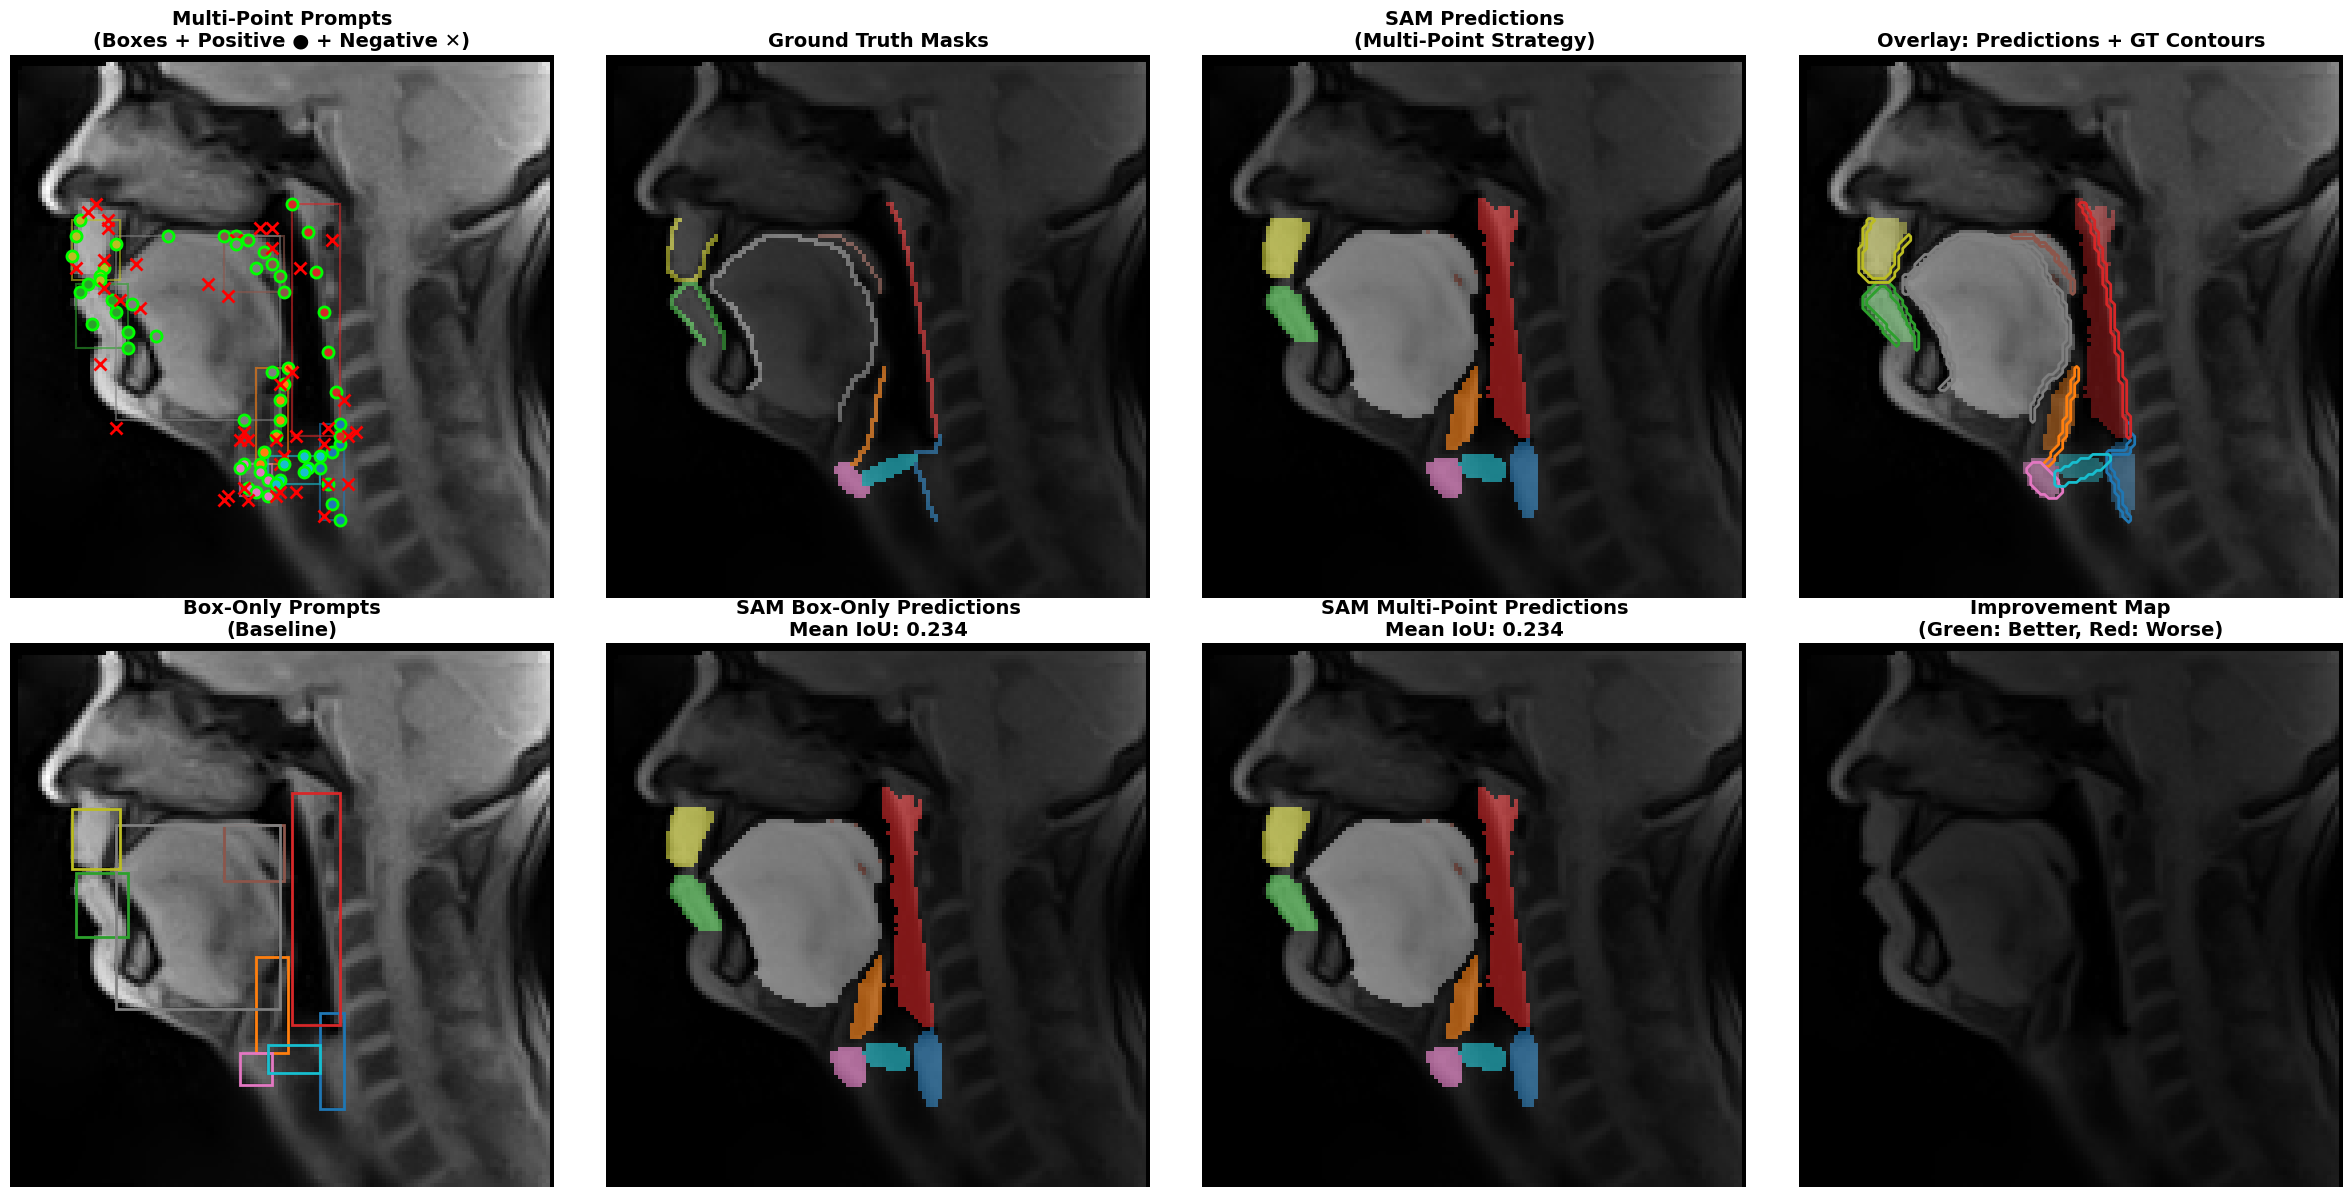

In [41]:
# Visualize multi-point prompting results
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

# Create combined masks
sam_multipoint_combined = np.zeros((*img_array.shape, 3))
for i, class_name in enumerate(classes):
    if class_name in sam_multipoint_predictions and sam_multipoint_predictions[class_name] is not None:
        sam_multipoint_combined[sam_multipoint_predictions[class_name]] = colors[i][:3]

# Row 1: Show prompts and predictions
# Column 1: All multi-point prompts
axes[0, 0].imshow(img_normalized, cmap='gray')
for i, (art_name, prompt_data) in enumerate(multipoint_prompts.items()):
    color = colors[classes.index(art_name)][:3]
    
    # Draw box
    box = prompt_data['box']
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=1.5, edgecolor=color, facecolor='none', alpha=0.6)
    axes[0, 0].add_patch(rect)
    
    # Draw positive points (green edge)
    for pt in prompt_data['positive_points']:
        axes[0, 0].plot(pt[0], pt[1], 'o', color=color, markersize=8, 
                       markeredgecolor='lime', markeredgewidth=2)
    
    # Draw negative points (red edge)
    for pt in prompt_data['negative_points']:
        axes[0, 0].plot(pt[0], pt[1], 'x', color='red', markersize=8, markeredgewidth=2)

axes[0, 0].set_title('Multi-Point Prompts\n(Boxes + Positive ● + Negative ✕)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Column 2: Ground Truth
axes[0, 1].imshow(img_normalized, cmap='gray')
axes[0, 1].imshow(gt_combined, alpha=0.6)
axes[0, 1].set_title('Ground Truth Masks', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Column 3: Multi-point predictions
axes[0, 2].imshow(img_normalized, cmap='gray')
axes[0, 2].imshow(sam_multipoint_combined, alpha=0.6)
axes[0, 2].set_title('SAM Predictions\n(Multi-Point Strategy)', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Column 4: Comparison overlay
axes[0, 3].imshow(img_normalized, cmap='gray')
axes[0, 3].imshow(sam_multipoint_combined, alpha=0.4)
for i, class_name in enumerate(classes):
    if class_name in gt_masks_dict:
        axes[0, 3].contour(gt_masks_dict[class_name], colors=[colors[i][:3]], linewidths=2)
axes[0, 3].set_title('Overlay: Predictions + GT Contours', fontsize=14, fontweight='bold')
axes[0, 3].axis('off')

# Row 2: Comparison with box-only method
# Column 1: Box-only prompts
axes[1, 0].imshow(img_normalized, cmap='gray')
for i, (art_name, prompt_info) in enumerate(prompts.items()):
    box = prompt_info['box']
    color = colors[i][:3]
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=2, edgecolor=color, facecolor='none')
    axes[1, 0].add_patch(rect)
axes[1, 0].set_title('Box-Only Prompts\n(Baseline)', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# Column 2: Box-only predictions
axes[1, 1].imshow(img_normalized, cmap='gray')
axes[1, 1].imshow(sam_box_combined, alpha=0.6)
axes[1, 1].set_title(f'SAM Box-Only Predictions\nMean IoU: {mean_iou:.3f}', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

# Column 3: Multi-point predictions (repeat)
axes[1, 2].imshow(img_normalized, cmap='gray')
axes[1, 2].imshow(sam_multipoint_combined, alpha=0.6)
axes[1, 2].set_title(f'SAM Multi-Point Predictions\nMean IoU: {mean_iou_multipoint:.3f}', fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

# Column 4: Difference visualization
axes[1, 3].imshow(img_normalized, cmap='gray')
# Show where multi-point is better (green) or worse (red)
improvement_mask = np.zeros((*img_array.shape, 3))
for i, class_name in enumerate(classes):
    if (class_name in sam_predictions and sam_predictions[class_name] is not None and
        class_name in sam_multipoint_predictions and sam_multipoint_predictions[class_name] is not None and
        class_name in gt_masks_dict):
        
        box_pred = sam_predictions[class_name]
        multi_pred = sam_multipoint_predictions[class_name]
        gt = gt_masks_dict[class_name]
        
        # Improvements: multi-point correct, box-only wrong
        improvements = multi_pred & gt & ~(box_pred & gt)
        improvement_mask[improvements] = [0, 1, 0]  # Green
        
        # Regressions: box-only correct, multi-point wrong
        regressions = box_pred & gt & ~(multi_pred & gt)
        improvement_mask[regressions] = [1, 0, 0]  # Red

axes[1, 3].imshow(improvement_mask, alpha=0.7)
axes[1, 3].set_title('Improvement Map\n(Green: Better, Red: Worse)', fontsize=14, fontweight='bold')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()
